# Image classification
A machine learning model for image classification for three different classes

#  Libraries
Import all required libraries and modules 

In [1]:

import sys
sys.path.append('../input/imutils-054/imutils-0.5.4')

In [2]:
import imutils
import os
import cv2
import datetime
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer

import pickle

In [3]:
data = [] # variable to store dataset
labels = [] # varaible to store data labels
imagePaths = [] # paths to images

# Load data into the system

In [4]:
images_path = "../input/caltech101-airplanes-motorbikes-schooners/caltech101_classification"

In [5]:
#We define three classes in accordance with the provided dataSet
classes = ["Motorbikes", "airplanes", "schooner"]

In [6]:
# @returns the number of images for each classes
def classes_counter(labels, class_name):
    num = 0
    for l in labels:
        if l == class_name:
            num += 1
    return num

In [7]:
# For each of the classes in dataset
for imageClass in classes:
    images = [] 
    imagePath = images_path + "/" + imageClass + "/" #build a constructive path for each image class
    print(imagePath)
    # get the list of the available images
    for image in os.listdir(imagePath): # get list of images for each imageClass
        if (image.endswith(".jpg")):
            images.append(image)
    images = sorted(images)  
    # loop over the images
    for img in images:
        label = imageClass
        image_path = os.path.sep.join([images_path, imageClass, img])
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]
        # load the image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
        data.append(image)
        labels.append(label)
        imagePaths.append(image_path)

../input/caltech101-airplanes-motorbikes-schooners/caltech101_classification/Motorbikes/
../input/caltech101-airplanes-motorbikes-schooners/caltech101_classification/airplanes/
../input/caltech101-airplanes-motorbikes-schooners/caltech101_classification/schooner/


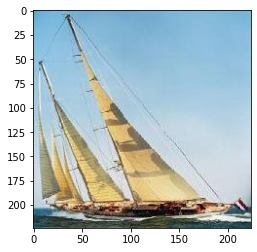

In [8]:
# show the output image
imgplot = plt.imshow(image.astype('uint8'))
plt.show()

# Data Preprocessing

In [9]:
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_sch = classes_counter(labels, "schooner")

counter_mtb, counter_arp, counter_sch

(798, 800, 63)

As we we see above, there are 1596 Motorbike images, 1600 airplane images and 126 schooner images.
We can see number of images for class schooner is significantly less than other two classes. We are going to augument the image class
schooner. Furthermore, we will do scaling and rotating

In [11]:
maxNumber = max(counter_mtb, counter_arp, counter_sch)

In [12]:
#@returns scaled image
def scaleImage(img):
    scale_val = random.uniform(0.8, 1.2) #scale uniformaly
    imgScaled = cv2.resize(img.copy(), 
                           None, 
                           fx=scale_val, 
                           fy=scale_val)
    
    return imgScaled

In [13]:
#@returns rotated image
def rotate(img):
    #get the height and width of input image
    (h, w) = img.shape[:2]
    rotate_val = random.uniform(-5, 5) #range of degree
    center = (w / 2, h / 2)  #center of imahe
    M = cv2.getRotationMatrix2D(center, 
                                rotate_val, 
                                scale=1) # rotate a matrix
    
    imgRotated = cv2.warpAffine(img.copy(), 
                                M, 
                                (w, h))
    return imgRotated

In [19]:
#@augments the image class
def augmentData(counter, max_number, class_name):
    while counter < max_number:
        # do this for each image in dataset
        for img in data:
            if counter < max_number:
                #scaling factor
                imgAug = img.copy()
                imgAug = scaleImage(imgAug)
                # new image
                cv2.imwrite("imgAug.jpg", imgAug)
                #load augmented image
                imgAug = load_img("imgAug.jpg", target_size=(224, 224))
                imgAug = img_to_array(imgAug)
                # delete it from memory
                os.remove("imgAug.jpg")
                #add new image to dataset
                data.append(imgAug)
                labels.append(class_name)
                imagePaths.append(image_path)
                
#                 calculate counter
                counter = classes_counter(labels, class_name)
            else:
                break

            #rotate
            if counter < max_number:
                imgAug = img.copy()
                imgAug = rotate(imgAug)
                
                cv2.imwrite("imgAug.jpg", imgAug)
                
                imgAug = load_img("imgAug.jpg", target_size=(224, 224))
                imgAug = img_to_array(imgAug)
                os.remove("imgAug.jpg")
                data.append(imgAug)
                labels.append(class_name)
                imagePaths.append(image_path)
                counter = classes_counter(labels, class_name)
            else:
                break

In [20]:
augmentData(counter_mtb, max_number, "Motorbikes")
augmentData(counter_sch, max_number, "schooner")

## How many new images after augmentation?

In [21]:
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_sch = classes_counter(labels, "schooner")

counter_mtb, counter_arp, counter_sch

(800, 800, 800)

In [22]:
#Normalize the data
data = np.array(data, dtype="float32") / 255.0

Let's convert everything else to **numpy arrays** also.

In [23]:
# convert to numpy array for easy manupalation
labels = np.array(labels)
imagePaths = np.array(imagePaths)

In [25]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [26]:
# check frequency classification
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)

## Split the data into training and testing set

In [27]:
split = train_test_split(data,
                         labels,
                         imagePaths,
                         test_size=0.05,
                         random_state=42)

 unpack *split* variable to different variables.

In [28]:
# here we unpack the data split 
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainPaths, testPaths) = split[4:]

Here, we save the names of the test images in a text file. This will be used to test a neural network later

In [29]:
f = open("testing_multiclass.txt", "w")
f.write("\n".join(testPaths))
f.close()

# Developing a neural network
Here we'll use VGG16 neural network.

In [30]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

2022-10-21 20:23:27.813591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 20:23:27.929577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 20:23:27.930398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 20:23:27.932126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [31]:
# freeze all layers for our model 
vgg.trainable = False

In [32]:
# flatten the output
flatten = vgg.output
flatten = Flatten()(flatten)

In [33]:
# construct a fully connected layer
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)

softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [34]:
model = Model(
    inputs=vgg.input,
    outputs=(softmaxHead))

In [35]:
INIT_LR = 1e-4
NUM_EPOCHS = 40
BATCH_SIZE = 32

define a dictionary to set the loose method

In [36]:
losses = {
    "class_label": "categorical_crossentropy",
}

define a dictionary for our target training output

In [37]:
trainTargets = {
    "class_label": trainLabels,
}

Define another dictionary for target testing output

In [38]:
testTargets = {
    "class_label": testLabels,
}

save only the best model

In [39]:
model_path = "model.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Compile the model and show the model summaray

In [40]:
opt = Adam(INIT_LR)

model.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Train VGG16 network for our dataset and save the model for later use

In [41]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback],
    verbose=1)

2022-10-21 20:28:01.988118: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1372815360 exceeds 10% of free system memory.
2022-10-21 20:28:03.508468: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1372815360 exceeds 10% of free system memory.
2022-10-21 20:28:04.615752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-10-21 20:28:06.207023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 19s 120ms/step - loss: 0.6291 - accuracy: 0.6952 - val_loss: 0.3398 - val_accuracy: 0.8500
Epoch 2/40
72/72 [==============================] - 5s 70ms/step - loss: 0.3905 - accuracy: 0.8149 - val_loss: 0.2764 - val_accuracy: 0.8583
Epoch 3/40
72/72 [==============================] - 5s 71ms/step - loss: 0.3230 - accuracy: 0.8539 - val_loss: 0.2289 - val_accuracy: 0.9000
Epoch 4/40
72/72 [==============================] - 5s 70ms/step - loss: 0.2794 - accuracy: 0.8794 - val_loss: 0.2005 - val_accuracy: 0.9000
Epoch 5/40
72/72 [==============================] - 5s 70ms/step - loss: 0.2157 - accuracy: 0.9075 - val_loss: 0.1783 - val_accuracy: 0.9333
Epoch 6/40
72/72 [==============================] - 5s 71ms/step - loss: 0.1892 - accuracy: 0.9154 - val_loss: 0.1620 - val_accuracy: 0.9167
Epoch 7/40
72/72 [==============================] - 5s 70ms/step - loss: 0.1563 - accuracy: 0.9316 - val_loss: 0.2362 - val_accuracy: 0.9083
Epoch 8/40
72/72 [====

In [42]:
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

# Here we will plot loss and accuracy of the model

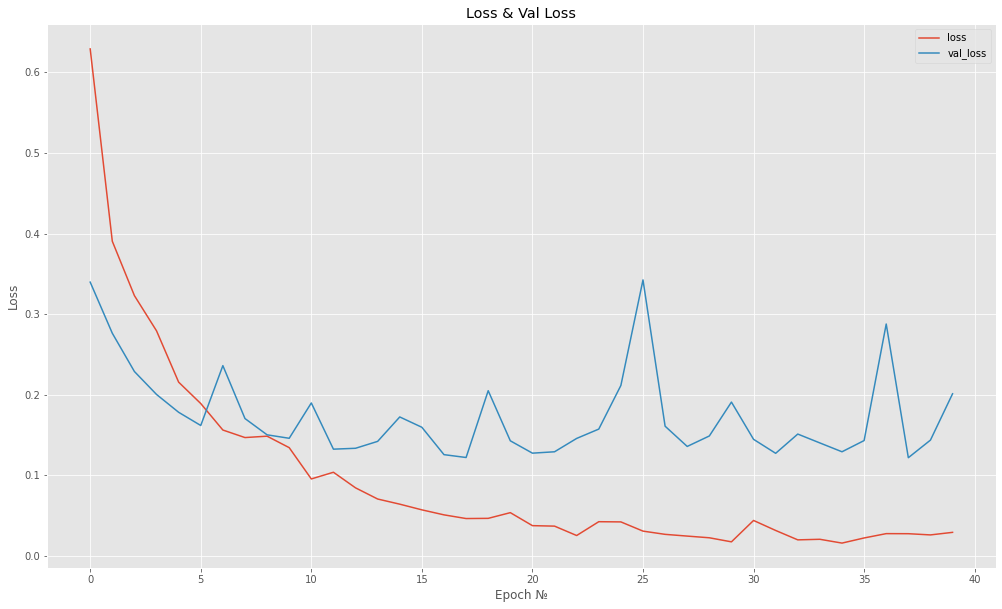

In [43]:
lossNames = ["loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))
#plot
plt.title("Loss & Val Loss")
plt.xlabel("Epoch №")
plt.ylabel("Loss")
plt.plot(N, H.history["loss"], label="loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

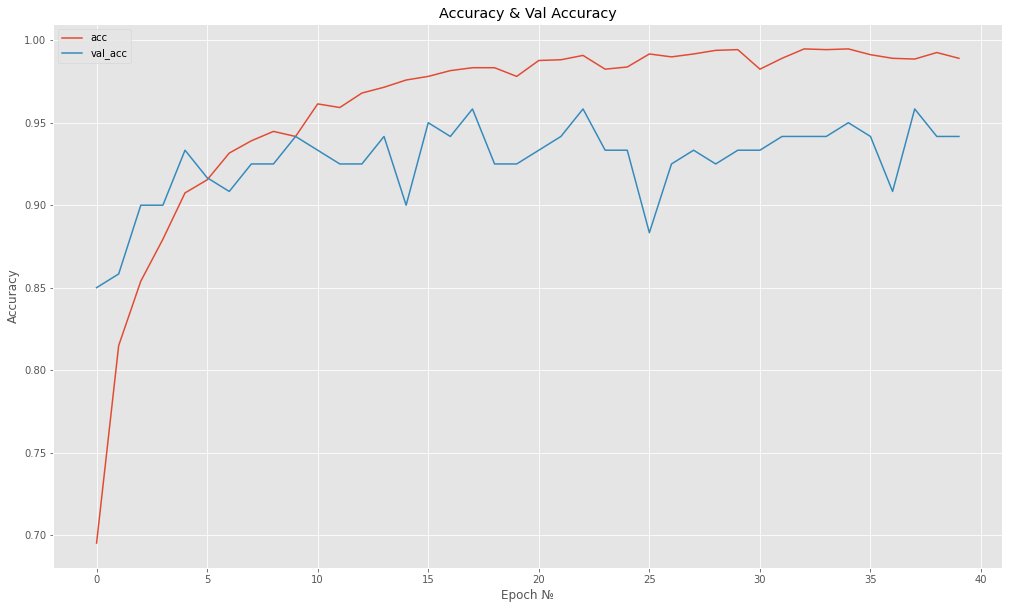

In [44]:
# plot for accuracy depection
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))

plt.plot(N, H.history["accuracy"], label="acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")

plt.title("Accuracy & Val Accuracy")
plt.xlabel("Epoch №")
plt.ylabel("Accuracy")
plt.legend()

# Testing the model

In [45]:
path = "testing_multiclass.txt"
filenames = open(path).read().strip().split("\n")
imagePaths = []

for f in filenames:
    imagePaths.append(f)

In [46]:
#load the trained model into the system
model = load_model("./model.h5")

In [47]:
#load and unpiclke the test images data
lb = pickle.loads(open("./lb.pickle", "rb").read())

### predicting classes for images dataset

class label =  2


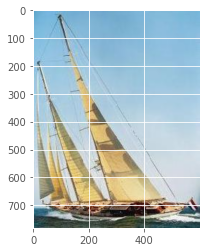

class label =  2


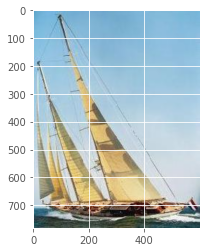

class label =  1


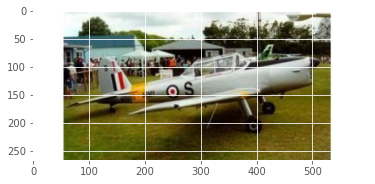

class label =  2


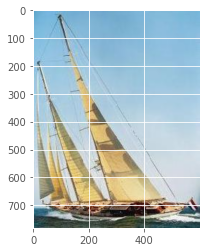

class label =  2


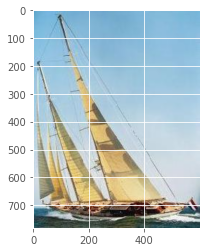

class label =  0


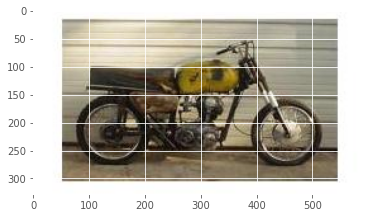

class label =  1


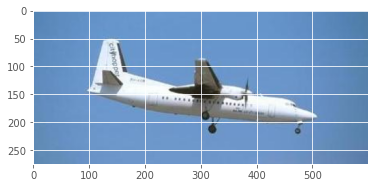

class label =  2


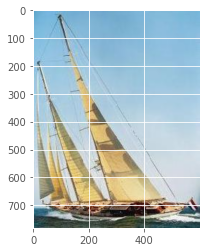

class label =  1


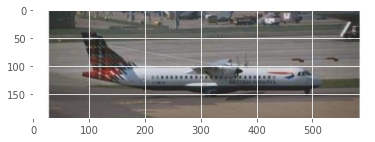

class label =  1


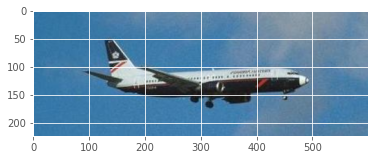

class label =  2


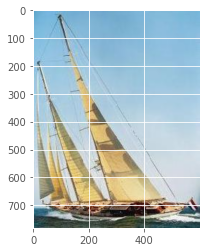

In [48]:

cntr = 0 # couter for images
for imagePath in imagePaths:
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    (labelPreds) = model.predict(image) # predict
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    print("class label = ", label)
    imgplot = plt.imshow(cv2.cvtColor(image, 
                                      cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()
    cntr += 1
    if (cntr > 10):
        break

### Conclusion
The model we trained predicts the right classes for the images quite well